In [1]:
from pyscf import gto, scf
import numpy as np
#import matplotlib.pyplot as plt
# from pyscf.geomopt.berny_solver import optimize
from pyscf.grad import rhf as grhf
#from pyscf.hessian import rhf as hrhf
from pyscf import lib
import inspect
from functools import reduce
from pyscf.scf import cphf
angstrom = 1 / 0.52917721067
from pyscf.scf._response_functions import _gen_rhf_response 
def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[0])
    dV=mol.intor('int1e_rinv')*dL[0]
    mol.set_rinv_orig_(mol.atom_coords()[1])
    dV+=mol.intor('int1e_rinv')*dL[1]
    return -dV

In [2]:
import matplotlib.pyplot as plt


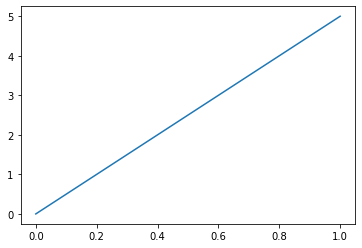

In [3]:
plt.plot([0,1],[0,5])

In [4]:
mol = gto.M(atom='C 0 0 0; O 0 0 1.2', unit="Bohr",basis="sto-3g")
mf = scf.RHF(mol)
e=mf.scf()

converged SCF energy = -108.485919016289


In [5]:
g = mf.Gradients()
g.kernel()

--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000    -0.0000000000    10.3428116554
1 O    -0.0000000000     0.0000000000   -10.3428116554
----------------------------------------------


array([[ 5.90650032e-16, -8.08191869e-17,  1.03428117e+01],
       [-5.90650032e-16,  8.08191869e-17, -1.03428117e+01]])

In [6]:
"""class GradientsBasics(lib.StreamObject):
    '''
    Basic nuclear gradient functions for non-relativistic methods
    '''
    def __init__(self, method):
        self.verbose = method.verbose
        self.stdout = method.stdout
        self.mol = method.mol
        self.base = method
        self.max_memory = self.mol.max_memory
        self.atmlst = None
        self.de = None
        self._keys = set(self.__dict__.keys())
"""

"class GradientsBasics(lib.StreamObject):\n    '''\n    Basic nuclear gradient functions for non-relativistic methods\n    '''\n    def __init__(self, method):\n        self.verbose = method.verbose\n        self.stdout = method.stdout\n        self.mol = method.mol\n        self.base = method\n        self.max_memory = self.mol.max_memory\n        self.atmlst = None\n        self.de = None\n        self._keys = set(self.__dict__.keys())\n"

The formula for the gradient is stated in Pople's article (Eq.21) as: 
$$ \frac{\partial E}{\partial x}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial x}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial x}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial x} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial x}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

 In order to evaluate the mixed derivative $\frac {\partial^2 E}{\partial Z \partial x } $we need to :<br>
 1)Build the gradient from scratch and understand each individual piece <br>
 2)Derive the expression with respect to $Z$. Will require the $\frac{\partial P}{\partial Z} $ that can be obtained analytically through CPHF once for all normal modes. Might be non trivial $\frac {\partial^2 H}{\partial Z \partial x}$ element. $\partial_Z \partial_x V_{nuc}$ is classical mechanics. $\partial_Z W$ is also easy through the $U$ matrix response of CPHF. $\partial_Z \partial_x(\mu \lambda | | \nu\sigma)=0$ as well as $\partial_Z S=0$

# Let's start inspecting the explicit gradient expression from PySCF

In [24]:
print(inspect.getsource(g.kernel))
print(inspect.getsource(g.grad_elec))
print(inspect.getsource(grhf.make_rdm1e))

    def kernel(self, mo_energy=None, mo_coeff=None, mo_occ=None, atmlst=None):
        cput0 = (time.clock(), time.time())
        if mo_energy is None: mo_energy = self.base.mo_energy
        if mo_coeff is None: mo_coeff = self.base.mo_coeff
        if mo_occ is None: mo_occ = self.base.mo_occ
        if atmlst is None:
            atmlst = self.atmlst
        else:
            self.atmlst = atmlst

        if self.verbose >= logger.WARN:
            self.check_sanity()
        if self.verbose >= logger.INFO:
            self.dump_flags()

        de = self.grad_elec(mo_energy, mo_coeff, mo_occ, atmlst)
        self.de = de + self.grad_nuc(atmlst=atmlst)
        if self.mol.symmetry:
            self.de = self.symmetrize(self.de, atmlst)
        logger.timer(self, 'SCF gradients', *cput0)
        self._finalize()
        return self.de

def grad_elec(mf_grad, mo_energy=None, mo_coeff=None, mo_occ=None, atmlst=None):
    '''
    Electronic part of RHF/RKS gradients

    Args:
        

In [25]:
mf.mo_occ

array([2., 2., 2., 2., 2., 2., 2., 0., 0., 0.])

In [8]:
"""
This is the important code ----------------------------------------------------------------

hcore_deriv = mf_grad.hcore_generator(mol)                  dH/dx as a function of (at_idx)
s1 = mf_grad.get_ovlp(mol)%autocall                         dS/dx   
dm0 = mf.make_rdm1(mo_coeff, mo_occ)                          P

vhf = mf_grad.get_veff(mol, dm0)                           P ( d/dx(ml) || ns )

dme0 = mf_grad.make_rdm1e(mo_energy, mo_coeff, mo_occ)        W

atmlst = range(mol.natm)
aoslices = mol.aoslice_by_atom()
de = numpy.zeros((len(atmlst),3))
for k, ia in enumerate(atmlst):
    p0, p1 = aoslices [ia,2:]
    h1ao = hcore_deriv(ia) 
    de[k] += numpy.einsum('xij,ij->x', h1ao, dm0)                                    P*dH/dx
# nabla was applied on bra in vhf, *2 for the contributions of nabla|ket>
    de[k] += numpy.einsum('xij,ij->x', vhf[:,p0:p1], dm0[p0:p1]) * 2        #   P (Pd/dx(ml||ns))    -as construction on dm0
    de[k] -= numpy.einsum('xij,ij->x', s1[:,p0:p1], dme0[p0:p1]) * 2        W dS/dx

    de[k] += mf_grad.extra_force(ia, locals())   # grid reponce for DFT only

return de
""" 
pass

In [9]:
#print(inspect.getsource(g.extra_force))

 Think how to get $\frac{\partial^2 H^{(1)}_{ij}}{\partial Z \partial x}$

In [10]:
#print(inspect.getsource(g.hcore_generator))

In [11]:
print(getattr(g.base, 'with_x2c', None))

None


In [12]:
molh2=gto.M(atom="H 0 0 0; H 0 0 1.3",unit="Bohr")
mfh2=scf.RHF(molh2)
mfh2.scf()
h1 = mfh2.get_hcore(molh2)

converged SCF energy = -1.11687114045084


In [13]:
"""
Idealy the mixed derivative can be obtained just dividing by Z_I , or omitting to multiply by Z_I 

def hcore_generator(mf, mol=None):
    if mol is None: mol = mf.mol
    with_x2c = getattr(mf.base, 'with_x2c', None)
    if with_x2c:                                                 # standard molecules has not x2c
        hcore_deriv = with_x2c.hcore_deriv_generator(deriv=1)
    else:
        with_ecp = mol.has_ecp()
        if with_ecp:
            ecp_atoms = set(mol._ecpbas[:,gto.ATOM_OF])
        else:
            ecp_atoms = ()
        aoslices = mol.aoslice_by_atom()
        h1 = mf.get_hcore(mol)
        def hcore_deriv(atm_id):
            shl0, shl1, p0, p1 = aoslices[atm_id]
            with mol.with_rinv_at_nucleus(atm_id):
                vrinv = mol.intor('int1e_iprinv', comp=3) # <\nabla|1/r**2|>
                vrinv *= -mol.atom_charge(atm_id)        <--------------------------------  we shall act here
                if with_ecp and atm_id in ecp_atoms:
                    vrinv += mol.intor('ECPscalar_iprinv', comp=3)
            vrinv[:,p0:p1] += h1[:,p0:p1]
            return vrinv + vrinv.transpose(0,2,1)
    return hcore_deriv
"""
pass

In [14]:
g_h2=mfh2.Gradients()
g_h2.run()
g_h2.hcore_generator()(0)
h1=g_h2.get_hcore()
g_h2.get_hcore()

--------------- RHF gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0283400377
1 H     0.0000000000     0.0000000000    -0.0283400377
----------------------------------------------


array([[[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.18425078, -0.41623511],
        [ 0.41623511,  0.18425078]]])

In [15]:
from FcMole import FcM
fm=FcM(fcs=[0.5,-0.5],atom="H 0 0 0; H 0 0 1.3",unit="Bohr")
fmf=scf.RHF(fm)
fmf.kernel(dm0=fmf.init_guess_by_atom())
g_fm=fmf.Gradients()
g_fm.kernel()


WARN: Found fractional number of electrons 1.500000. Round it to 2


WARN: Found fractional number of electrons 1.500000. Round it to 2


WARN: Found fractional number of electrons 1.500000. Round it to 2



******** <class 'pyscf.scf.atom_hf.AtomSphericAverageRHF'> ********
method = AtomSphericAverageRHF-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/administrator/Documenti/APDFT/prototyping/hessian/AAFF/0_notebooks for theory/tmpj1p7kbyv
max_memory 4000 MB (current use 143 MB)

WARN: Found fractional number of electrons 1.500000. Round it to 2

Set gradient conv threshold to 3.16228e-05


RuntimeError: Core configuration for %d core electrons is not available.

In [16]:
g_h2.hcore_generator()(0)

array([[[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.36850155, -0.6402839 ],
        [-0.6402839 , -0.36850155]]])

In [17]:
atm_id=0
with molh2.with_rinv_at_nucleus(atm_id):
    vrinv = -molh2.intor('int1e_iprinv', comp=3)
shl0, shl1, p0, p1 = molh2.aoslice_by_atom()[atm_id]
vrinv[:,p0:p1] += h1[:,p0:p1]   
vrinv += vrinv.transpose(0,2,1)
vrinv

array([[[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.36850155, -0.6402839 ],
        [-0.6402839 , -0.36850155]]])

In [18]:
with fm.with_rinv_at_nucleus(1):
    vrinv = -fm.intor('int1e_iprinv', comp=3)
vrinv

array([[[-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00]],

       [[-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00]],

       [[ 1.84250777e-01,  4.90251756e-01],
        [-2.66202967e-01, -6.23839931e-17]]])

In [19]:
g_h2.get_hcore()

array([[[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.18425078, -0.41623511],
        [ 0.41623511,  0.18425078]]])

In [20]:
"""def get_hcore(mol):
    '''Part of the nuclear gradients of core Hamiltonian'''
    h = mol.intor('int1e_ipkin', comp=3)
    if mol._pseudo:
        NotImplementedError('Nuclear gradients for GTH PP')
    else:
        h+= mol.intor('int1e_ipnuc', comp=3) <--------  work on this
    if mol.has_ecp():
        h += mol.intor('ECPscalar_ipnuc', comp=3)
    return -h
    
    def intor(self, intor, comp=None, hermi=0, aosym='s1', out=None, shls_slice=None):
    .....
        return moleintor.getints(intor, self._atm, bas, self._env,  < ------ cambio environment atm 
                                 shls_slice, comp, hermi, aosym, out=out)
    """

"def get_hcore(mol):\n    '''Part of the nuclear gradients of core Hamiltonian'''\n    h = mol.intor('int1e_ipkin', comp=3)\n    if mol._pseudo:\n        NotImplementedError('Nuclear gradients for GTH PP')\n    else:\n        h+= mol.intor('int1e_ipnuc', comp=3) <--------  work on this\n    if mol.has_ecp():\n        h += mol.intor('ECPscalar_ipnuc', comp=3)\n    return -h\n    \n    def intor(self, intor, comp=None, hermi=0, aosym='s1', out=None, shls_slice=None):\n    .....\n        return moleintor.getints(intor, self._atm, bas, self._env,  < ------ cambio environment atm \n                                 shls_slice, comp, hermi, aosym, out=out)\n    "

In [21]:
np.allclose(molh2.intor('int1e_ipkin', comp=3),fm.intor('int1e_ipkin', comp=3)) #buono,così non entra nelle derivate alchemiche

True

In [22]:
#we can see here that [0,0] element for the f.c.m. is half and the [1,1] element is 1.5 time bigger 
np.allclose(g_h2.get_hcore()- g_fm.get_hcore(),\
            -(molh2.intor('int1e_ipnuc', comp=3)-fm.intor('int1e_ipnuc', comp=3)))   # attento al meno

NameError: name 'g_fm' is not defined

In [72]:
molh2.intor('int1e_ipnuc', comp=3),fm.intor('int1e_ipnuc', comp=3)

(array([[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.18425078,  0.75645472],
         [-0.75645472, -0.18425078]]]),
 array([[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.09212539,  0.64443033],
         [-0.86847912, -0.27637616]]]))

In [43]:
fm._env,molh2._env

(array([137.03599968,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   1.5       ,
          0.        ,   0.        ,   1.3       ,   0.5       ,
          3.42525091,   0.62391373,   0.1688554 ,   0.98170675,
          0.94946401,   0.29590645]),
 array([137.03599968,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.3       ,   0.        ,
  

In [44]:
molh2._atm,fm._atm

(array([[ 1, 20,  1, 23,  0,  0],
        [ 1, 24,  1, 27,  0,  0]], dtype=int32),
 array([[ 1, 20,  3, 23,  0,  0],
        [ 1, 24,  3, 27,  0,  0]], dtype=int32))

In [46]:
molh2._bas,fm._bas

(array([[ 0,  0,  3,  1,  0, 28, 31,  0],
        [ 1,  0,  3,  1,  0, 28, 31,  0]], dtype=int32),
 array([[ 0,  0,  3,  1,  0, 28, 31,  0],
        [ 1,  0,  3,  1,  0, 28, 31,  0]], dtype=int32))

In [73]:
#getints(intor, self._atm, bas, self._env,  , shls_slice, comp, hermi, aosym, out=out)
gto.moleintor.getints('int1e_ipnuc_sph',molh2._atm,molh2._bas,molh2._env, None,3,0,'s1').astype('float')

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.18425078,  0.75645472],
        [-0.75645472, -0.18425078]]])

In [70]:
molh2.intor('int1e_ipnuc', comp=3)
molh2._add_suffix('int1e_ipnuc')

'int1e_ipnuc_sph'

In [ ]:
np.allclose(g_h2.get_hcore()- g_fm.get_hcore(),\
            -(molh2.intor('int1e_ipnuc', comp=3)-fm.intor('int1e_ipnuc', comp=3)))

In [74]:
#costruiamo ora un ambiente con le cariche frazionarie differenza delle due molecole, e un atm con parametri cariche frazionarie
NUC_FRAC_CHARGE=gto.mole.NUC_FRAC_CHARGE
NUC_MOD_OF=gto.mole.NUC_MOD_OF
PTR_FRAC_CHARGE=gto.mole.PTR_FRAC_CHARGE
denv=molh2._env.copy()
datm=molh2._atm.copy()
fcs=[.5,-.5]
datm[:,NUC_MOD_OF] = NUC_FRAC_CHARGE
for i in range (molh2.natm):
    denv[datm[i,PTR_FRAC_CHARGE]]=fcs[i]

In [75]:
gto.moleintor.getints('int1e_ipnuc_sph',datm,molh2._bas,denv, None,3,0,'s1').astype('float')

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-0.09212539, -0.11202439],
        [-0.11202439, -0.09212539]]])

In [76]:
g_h2.get_hcore()- g_fm.get_hcore()

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-0.09212539, -0.11202439],
        [-0.11202439, -0.09212539]]])

In [23]:
#print(g.hcore_generator()(1)),g.hcore_generator()(1).shape 
# hcore_generator() returns a function which can take as arguments the atm_idx and returns the dH/dX for X=x,y,z displacements
# to get the mixed derivative dive by atom charge(at_idx)

In [24]:
g.grad_elec()

array([[ 3.03286501e-16, -4.74250743e-17, -2.29905217e+01],
       [-3.03286501e-16,  4.74250743e-17,  2.29905217e+01]])

In [25]:
g.grad_nuc()  

array([[  0.        ,   0.        ,  33.33333333],
       [  0.        ,   0.        , -33.33333333]])

In [26]:
g.grad_elec()+g.grad_nuc(),g.grad()

--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000    -0.0000000000    10.3428116554
1 O    -0.0000000000     0.0000000000   -10.3428116554
----------------------------------------------


(array([[ 3.03286501e-16, -4.74250743e-17,  1.03428117e+01],
        [-3.03286501e-16,  4.74250743e-17, -1.03428117e+01]]),
 array([[ 3.03286501e-16, -4.74250743e-17,  1.03428117e+01],
        [-3.03286501e-16,  4.74250743e-17, -1.03428117e+01]]))

In [28]:
o=mf.mo_occ
e=mf.mo_energy
C=mf.mo_coeff

In [29]:
e,o*e

(array([-20.9670401 , -11.56776992,  -1.78979963,  -1.02216171,
         -1.02216171,  -0.7551287 ,  -0.50659282,   0.62851477,
          0.62851477,   1.7271854 ]),
 array([-41.9340802 , -23.13553984,  -3.57959927,  -2.04432341,
         -2.04432341,  -1.5102574 ,  -1.01318565,   0.        ,
          0.        ,   0.        ]))

In [30]:
np.allclose(C@np.diag(o*e)@C.T,g.make_rdm1e())

True